In [72]:
from crypto_chaotic import lorenz_attractor
import numpy as np
from math import sin, cos, sqrt

def chaos_commn(N = 3 , nosdata = 320000):
    xt = np.zeros(nosdata, dtype=np.float64)
    xr = np.zeros(nosdata, dtype=np.float64)
    signal = np.zeros(nosdata, dtype=np.float64)
    signal2 = np.zeros(nosdata, dtype=np.float64)
    recovered = np.zeros(nosdata, dtype=np.float64)
    encryptedx = np.zeros(nosdata, dtype=np.float64)
        
    tstep = 0.001
    ndrop = 15000
    xold = np.random.uniform(0, 1, size=N)
    print xold
    
    for i in range(ndrop):
        lorenz_attractor.rkm_send(tstep, xold, N)
        
    for i in range(nosdata):
        lorenz_attractor.rkm_send(tstep, xold, N)
        xt[i] = xold[0]
        
    #signal = np.random.uniform(-1, 1, size=nosdata)
    for i in range(nosdata):
        signal[i] = 0.15 * (5.0/10*sin(0.013 * i)+6.0/10*sin(0.012 * i)+7.0/10*sin(0.011 * i)+8.0/10*sin(0.010 * i)+9.0/10*sin(0.009 * i)+10.0/10*sin(0.008 * i))
        
        
    for i in range(nosdata):
        encryptedx[i] =  signal[i] + xt[i]
    
    
    xold = np.random.uniform(0, 1, size=N)
    print xold
    for i in range(ndrop):
        lorenz_attractor.rkm_send(tstep, xold, N)
        
    for i in range(nosdata):
        lorenz_attractor.rkm_receive(tstep, xold, encryptedx[i], N)
        xr[i] = xold[0]
        
    for i in range(nosdata):
        recovered[i] = encryptedx[i] - xr[i]
        
    return (signal, encryptedx, recovered, xt, xr)

In [73]:
signal, encryptedx, recovered, xt, xr = chaos_commn()
print signal
print encryptedx
print recovered

[ 0.55824406  0.9460469   0.91127741]
[ 0.96708103  0.61442395  0.87704267]
[ 0.          0.00682487  0.01364899 ...,  0.49160597  0.49110646
  0.49055406]
[ 10.29470237  10.23231473  10.16946075 ..., -12.10723501 -12.11068832
 -12.11327677]
[ 7.99904642  7.94553632  7.89131232 ...,  0.54468452  0.54427338
  0.54388162]


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


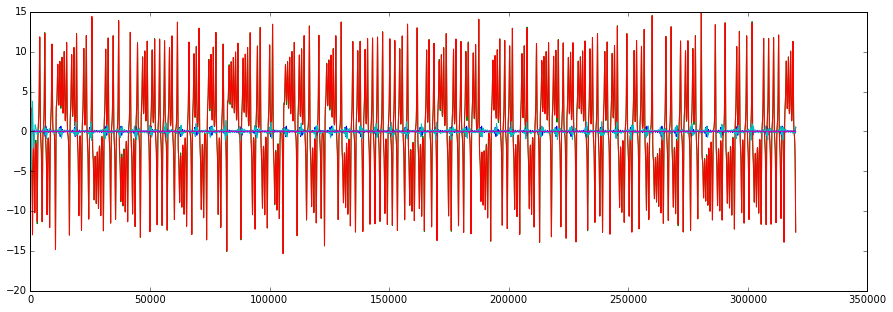

In [74]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt

def filter(encrypted, a): #dt, RC, N):    
    N = len(encrypted)
    y = np.zeros(N, dtype=np.float64)
    #a = 0.1 #RC / (RC + dt)
    y[0] = x[0]
    for i in range(1,N):
        y[i] = a * (y[i-1] + encrypted[i] - encrypted[i-1])
    return y

x = range(len(signal))
z = np.zeros(len(signal))

r = filter(encryptedx, 0.5)

plt.figure(figsize=(15, 5))

plt.plot(x,signal)
plt.plot(x,xt)
plt.plot(x,xr)
#plt.plot(x,xr-xt)
#plt.plot(x,z)
plt.plot(x,recovered)
plt.plot(x,r)
#plt.plot(x,encryptedx)
plt.show()

Populating the interactive namespace from numpy and matplotlib
10000


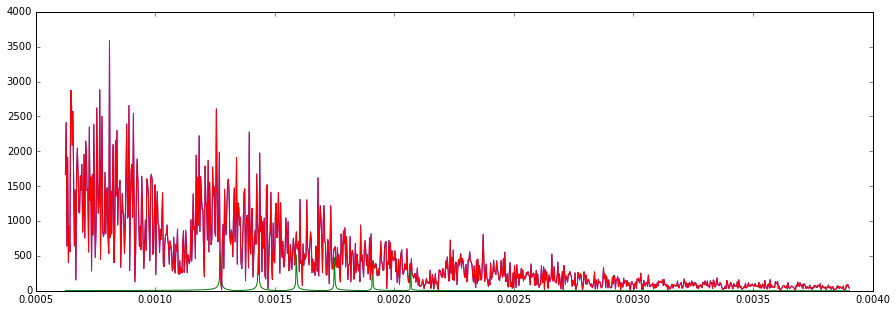

0.0
3.125e-06
-9.375e-06
-6.25e-06
-3.125e-06


In [75]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy
import scipy.fftpack


N = signal.size
t = range(0, N, 32) #scipy.linspace(0, N, N/128+1)

acc = lambda t: signal[t]
signal1 = acc(t)
print signal1.size
signal_FFT = abs(scipy.fft(signal1))
signal_freqs = scipy.fftpack.fftfreq(signal1.size, t[1]-t[0])

acc = lambda t: xt[t]
xt1 = acc(t)
xt_FFT = abs(scipy.fft(xt1))
xt_freqs = scipy.fftpack.fftfreq(xt1.size, t[1]-t[0])

acc = lambda t: xr[t] - xt[t]
err = acc(t)
err_FFT = abs(scipy.fft(err))
err_freqs = scipy.fftpack.fftfreq(err.size, t[1]-t[0])

acc = lambda t: r[t]
rr = acc(t)
rr_FFT = abs(scipy.fft(rr))
rr_freqs = scipy.fftpack.fftfreq(rr.size, t[1]-t[0])


plt.figure(figsize=(15, 5))
BB = 200
CC = 80000/64
#plt.subplot(211)
#plt.plot(t, signal1)
#plt.plot(t, xt1)
#plt.plot(t, encryptedx1)
#plt.subplot(212)
plt.plot(xt_freqs[BB:CC],xt_FFT[BB:CC])
plt.plot(signal_freqs[BB:CC],signal_FFT[BB:CC])
plt.plot(xt_freqs[BB:CC],xt_FFT[BB:CC])
#plt.plot(rr_freqs,scipy.log10(rr_FFT))
#plt.plot(x,xt)
#plt.plot(x,xr)
#plt.plot(x,recovered)
#plt.plot(x,encryptedx)
plt.show()
print xt_freqs[0]
print xt_freqs[1]
print xt_freqs[-3]
print xt_freqs[-2]
print xt_freqs[-1]

Populating the interactive namespace from numpy and matplotlib
10000


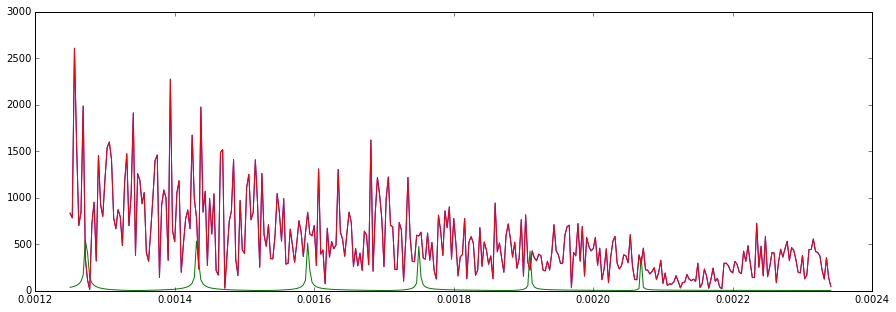

0.0
3.125e-06
-9.375e-06
-6.25e-06
-3.125e-06


In [81]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy
import scipy.fftpack


N = signal.size
t = range(0, N, 32) #scipy.linspace(0, N, N/128+1)

acc = lambda t: signal[t]
signal1 = acc(t)
print signal1.size
signal_FFT = abs(scipy.fft(signal1))
signal_freqs = scipy.fftpack.fftfreq(signal1.size, t[1]-t[0])

acc = lambda t: xt[t]
xt1 = acc(t)
xt_FFT = abs(scipy.fft(xt1))
xt_freqs = scipy.fftpack.fftfreq(xt1.size, t[1]-t[0])

acc = lambda t: xr[t] - xt[t]
err = acc(t)
err_FFT = abs(scipy.fft(err))
err_freqs = scipy.fftpack.fftfreq(err.size, t[1]-t[0])

acc = lambda t: r[t]
rr = acc(t)
rr_FFT = abs(scipy.fft(rr))
rr_freqs = scipy.fftpack.fftfreq(rr.size, t[1]-t[0])


plt.figure(figsize=(15, 5))
BB = 400
CC = 160000/64-1750
#plt.subplot(211)
#plt.plot(t, signal1)
#plt.plot(t, xt1)
#plt.plot(t, encryptedx1)
#plt.subplot(212)
plt.plot(xt_freqs[BB:CC],xt_FFT[BB:CC])
plt.plot(signal_freqs[BB:CC],signal_FFT[BB:CC])
plt.plot(xt_freqs[BB:CC],xt_FFT[BB:CC])
#plt.plot(rr_freqs,scipy.log10(rr_FFT))
#plt.plot(x,xt)
#plt.plot(x,xr)
#plt.plot(x,recovered)
#plt.plot(x,encryptedx)
plt.show()
print xt_freqs[0]
print xt_freqs[1]
print xt_freqs[-3]
print xt_freqs[-2]
print xt_freqs[-1]

Populating the interactive namespace from numpy and matplotlib


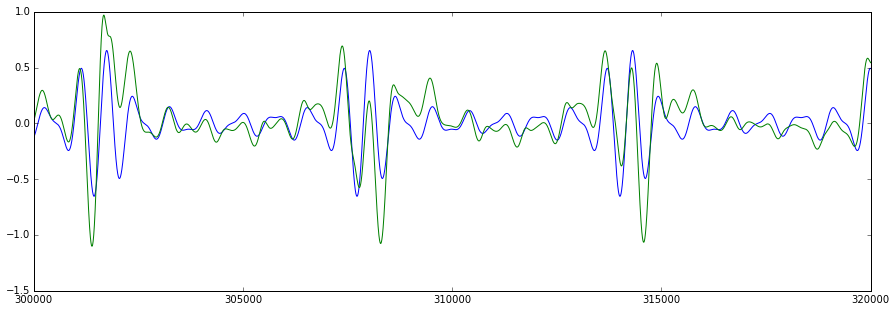

In [82]:
%pylab inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
x = range(len(signal))
z = np.zeros(len(signal))

plt.figure(figsize=(15, 5))

BB = -20000
CC = -1
plt.plot(x[BB:CC],signal[BB:CC])
#plt.plot(x[BB:CC],xt[BB:CC])
#plt.plot(x[BB:CC],xr[BB:CC])
#plt.plot(x[BB:CC],xr[BB:CC]-xt[BB:CC])
#plt.plot(x,z)
plt.plot(x[BB:CC],recovered[BB:CC])
#plt.plot(x[BB:CC],r[BB:CC])
#plt.plot(x,encryptedx)
plt.show()

313


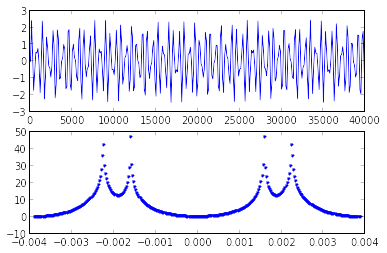

In [165]:
import scipy
import scipy.fftpack
import pylab
from scipy import pi
N = 40000
t = scipy.linspace(0, N, N/128+1)
acc = lambda t: 10*scipy.sin(2*pi*2.0*t) + 5*scipy.sin(2*pi*8.0*t) + 2*scipy.random.random(len(t))

acc = lambda t: 1.5 * sin(0.01 * t) + 1.0 * sin(0.01 * sqrt(2.0) * t)

signal = acc(t)
#signal = np.random.uniform(-1, 1, size=N)
print signal.size

FFT = abs(scipy.fft(signal))
freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])

pylab.subplot(211)
pylab.plot(t, signal)
pylab.subplot(212)
pylab.plot(freqs,20*scipy.log10(FFT),'.')
pylab.show()

4000 4000
4000 4000


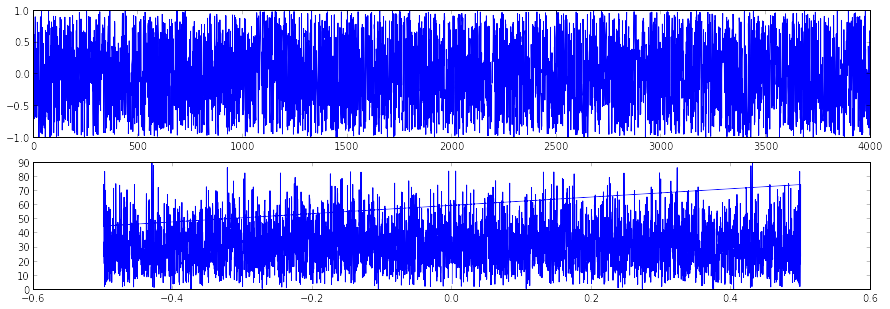

In [20]:
import scipy
import scipy.fftpack
import pylab
from scipy import pi
N = 4000
t = range(0, N, 1)
signal = np.random.uniform(-1, 1, size=N)

acc = lambda t: 10*scipy.sin(2*pi*2.0*t) + 5*scipy.sin(2*pi*8.0*t) + 2*scipy.random.random(len(t))

acc = lambda t: 1.5 * sin(0.01 * t) + 1.0 * sin(0.01 * sqrt(2.0) * t)

#signal = acc(t)
#signal = np.random.uniform(-1, 1, size=N)
print signal.size, len(t)

FFT = abs(scipy.fft(signal))
freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])

pylab.figure(figsize=(15, 5))

pylab.subplot(211)
pylab.plot(t, signal)
pylab.subplot(212)
pylab.plot(freqs,FFT)
print freqs.size, FFT.size
pylab.show()

In [14]:
print len(signal_FFT[10:])

1240


In [95]:
print range(0, 10, 1)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
